# Machine Learning Supervised Learning Techniques in Predicting Retail Bank Loan Defaults for Regulatory Purposes


In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.metrics import make_scorer, precision_score,confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import EditedNearestNeighbours


### 1.Introduction

Banks, globally use historic credit and borrower's information to asses the risk of lending to individuals and businesses, this type of infomation has been used both, in more traditional approaches such as credit scoring models, but also recently machine learning models have taken lead with their ability of predictive power. According to Bank of England's report on machine Learning in UK financial services (2022), 72% of firms already use or deploy machine learning technologies. Among the various use cases, credit related applications account for approximatively 10% of deployments and is one of the most critical for business area. 

Given the significant role of machine learning in credit and the critical impact that loan defaults have on a bank's capital, this project aims to explore the effectivness of supervised learning techniques in predicting bank loan defaults from a regulatory prespective, where if models are not able to predict accurately the bad loans, it would have an advesre risk on bank's capital and viability. 

The problem this project is trying to answer is :

**Can Retail banks rely on deploying machine learning technologies in predicting credit default of depositors?**

**Is supervised machine learning able to detect bad loans effectively and accurately, so that banks can manage its capital more efficiently?**

###### 1.1 Load data 

The dataset is downloaded from Kaggle, this dataset contains synthetic data that replicates infromation about credit applicants.The dataset contains 15 columns and 20,000 rows. The columns of the dataset means:
- __id__ = Index
- __grade__ = grade of loan
- __annual_inc__ = annual income of the applicant
- __short_emp__= 1 when applicant is employed less than a year
- __emp_length_num__ = employment in years from 0-10 
- __home_ownership__ = whether applicant rents, owns or has mortgage
- __dti__ = Debt-To-Income Ratio
- __purpose__ = reason why loan was taken
- __term__ = either can be 36 or 60 months 
- __last_delinq_none__ = 1 when the borrower had at least one event of delinquency
- __last_major_derog_none__ = 1 when applicant had at least 90 days of a bad rating
- __revol_util__ = the revovling line utlisation rate
- __total_rec_late_fee__ = total late fees
- __od_ratio__ = overdraft ratio
- __bad_loan__ = 1 when the loan has defaulted


One of the reasons for using this Kaggle dataset is that it contains synthetic data, meaning that it does not actually have actual information on real people. This ensures that as part of this project sensitive data is not handled, such as personal data, which otherwise would require strict compliance with regulations like GDPR. By using this synthetic data can allow to develop and test machine learning models purely for teoretical application rather than an actual real-world application. The dataset is created by Quasay AL-Btoush and can be found on this link: https://www.kaggle.com/datasets/qusaybtoush1990/machine-learning/data

In [2]:
#load data 
data= pd.read_csv('lending_club_loan_dataset.csv')
data.head(5)

,id,grade,annual_inc,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,od_ratio,bad_loan
0,11454641,A,100000.0,1,1,RENT,26.27,credit_card,36 months,1,NaN,43.2,0.0,0.160624,0
1,9604874,A,83000.0,0,4,OWN,5.39,credit_card,36 months,0,NaN,21.5,0.0,0.810777,0
2,9684700,D,78000.0,0,11,MORTGAGE,18.45,debt_consolidation,60 months,1,NaN,46.3,0.0,0.035147,1
3,9695736,D,37536.0,0,6,MORTGAGE,12.28,medical,60 months,0,NaN,10.7,0.0,0.534887,1
4,9795013,D,65000.0,0,11,MORTGAGE,11.26,debt_consolidation,36 months,0,NaN,15.2,0.0,0.166500,0


In [3]:
data.shape

(20000, 15)

The dataset contains 20,000 rows and 15 columns. 

### 2.Data cleaning 

In [4]:
#Check whether there are any duplicates
data.duplicated().sum()

np.int64(0)

In [5]:
#Check for missing values for each collumn as a sum
missing_values=data.isnull().sum()
print(missing_values)

id                           0
grade                        0
annual_inc                   0
short_emp                    0
emp_length_num               0
home_ownership            1491
dti                        154
purpose                      0
term                         0
last_delinq_none             0
last_major_derog_none    19426
revol_util                   0
total_rec_late_fee           0
od_ratio                     0
bad_loan                     0
dtype: int64


We can see that 3 columns have missing data, these are: 
- __home_ownership__  has 1,491 values missing out of 20,000 
- __dti__  has 154 values missing out of 20,000
- __last_major_derog_none__ has 19,426 values missing out of 20,000


Since __home_ownership__ is a categorial variable, the most common approach is to fill missing values with the __mode__ of the home_ownership column

In [6]:
data.loc[:, 'home_ownership'] = data['home_ownership'].fillna(data['home_ownership'].mode()[0])

Since __dti__ column, which stands for Debt-to-Income Ratio, is a continous variable, the best way to adress the missing values is to either impute the __mean__ or __median__ of that column data. To see which approach is better suited in this case would be good to understand whether there are any outliers that could screw the data.

<function matplotlib.pyplot.show(close=None, block=None)>

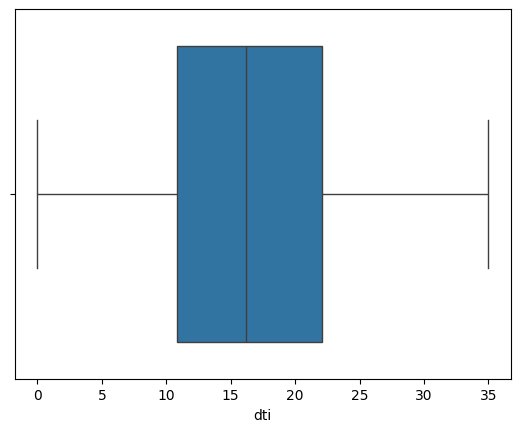

<Figure size 200x400 with 0 Axes>

In [7]:
# Do a boxplot to check for any outliers
sns.boxplot(x=data['dti'])
plt.figure(figsize=(2,4))
plt.show

The data is only slightly skewed to the right, therefore the missing values can be replaced by the mean as the boxplot did not show clear outliners and is only skewed slightly

In [8]:
data.loc[:, 'dti'] = data['dti'].fillna(data['dti'].mean())

Lastly, to address the missing values in the __last_major_derog_none__, which is a column that contains information on whether borrower had at 90 days of a bad rating (1= 90 days of bad rating, 0=false). Given that most values are missing, replacing with the mode might lead to inaccurate data, as we can see that most missing values would be replaced by 1. In this case there is not enough data to be able to do that, as such we drop the column, as the incomplete data will lead to inaccuarte results.


In [9]:
print(data['last_major_derog_none'].value_counts())

last_major_derog_none
1.0    436
0.0    138
Name: count, dtype: int64


In [10]:
data = data.drop('last_major_derog_none', axis=1)

In [11]:
#Check if any more data is missing, and what type of data is each column
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  20000 non-null  int64  
 1   grade               20000 non-null  object 
 2   annual_inc          20000 non-null  float64
 3   short_emp           20000 non-null  int64  
 4   emp_length_num      20000 non-null  int64  
 5   home_ownership      20000 non-null  object 
 6   dti                 20000 non-null  float64
 7   purpose             20000 non-null  object 
 8   term                20000 non-null  object 
 9   last_delinq_none    20000 non-null  int64  
 10  revol_util          20000 non-null  float64
 11  total_rec_late_fee  20000 non-null  float64
 12  od_ratio            20000 non-null  float64
 13  bad_loan            20000 non-null  int64  
dtypes: float64(5), int64(5), object(4)
memory usage: 2.1+ MB


Given that there are 4 collumns (__grade, home_ownership, purpose, term__) that have the __data type of object__ meaning it has text and numbers mixed, it would be necessary to convert it or encode the data because machine learning models require numerical data rather than text.

The __column grade__ has categorical data, specifically there are 7 types of loan grades ranging from A to B. A good way to transform the data into numerical is to map the grades from 1-7, especially beacuse the data is ordinal

In [12]:
#map the grades to numbers
grade_mapping = {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7}
#apply the mapping to the grade collumn 
data['grade'] = data['grade'].map(grade_mapping)

The __column purpose__ has categorical data ranging into 13 categories. For simplicity, the categories will be reduced to 4, this allows for better generalisation and with fewer categories machine learning models has an easier time to identify patterns.

In [13]:
#map the purpose to broader categories 
purpose_mapping = {'debt_consolidation':'debt', 
                   'credit_card': 'debt', 
                   'home_improvement':'home and lifestyle', 
                   'major_purchase':'health and personal',
                   'small_business': 'other', 
                   'medical':'health and personal', 
                   'car':'health and personal',
                   'moving':'home and lifestyle', 
                   'vacation':'home and lifestyle', 
                   'house':'home and lifestyle', 
                   'wedding':'home and lifestyle', 
                   'other':'other'}

#apply the mapping to the home ownership column 
data['purpose'] = data['purpose'].map(purpose_mapping)

In [14]:
data['purpose'].value_counts()

purpose
debt                   16474
home and lifestyle      1518
other                   1286
health and personal      722
Name: count, dtype: int64

And lastly the __column term__ is also a categorical data, however it also has a mismatch in 36 months one being with capital letter and the other with lower case. First is necessary to reconcile the difference so all loans that are termed at 36 months be put in one category. Then to make it into a numerical value we will drop the word months and just leave the numerical 36, 64 

In [15]:
#reconcile the capital letter with lower letter in 36 months, as well as deduct that most loans are termed at 36 months 
data['term'] = data['term'].str.strip().str.lower()

In [16]:
#map the grades to numbers
term_mapping = {'36 months':36, '60 months':60}
#apply the mapping to the term column 
data['term'] = data['term'].map(term_mapping)

In [17]:
data.head(5)

,id,grade,annual_inc,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,revol_util,total_rec_late_fee,od_ratio,bad_loan
0,11454641,1,100000.0,1,1,RENT,26.27,debt,36,1,43.2,0.0,0.160624,0
1,9604874,1,83000.0,0,4,OWN,5.39,debt,36,0,21.5,0.0,0.810777,0
2,9684700,4,78000.0,0,11,MORTGAGE,18.45,debt,60,1,46.3,0.0,0.035147,1
3,9695736,4,37536.0,0,6,MORTGAGE,12.28,health and personal,60,0,10.7,0.0,0.534887,1
4,9795013,4,65000.0,0,11,MORTGAGE,11.26,debt,36,0,15.2,0.0,0.166500,0


Now all data points have assigned a value, and the data is cleaned without any missing entries

### 3. Exploratory data analysis 

#### 3.1 Data understanding 

In order to model the data it is important to understand it, so that the features can be chosen more appropriatley. 

In [18]:
#This is the assigned loan grade, it would be important to understand how many loans of each grade the dataset contains
mapping = {1:'A', 2:'B', 3:'C', 4:'D', 5:'E', 6:'F',7: 'G'}
data['grade'].value_counts().rename(index=mapping, inplace= False)

grade
B    6042
C    5566
D    3554
A    2159
E    1645
F     865
G     169
Name: count, dtype: int64

In [19]:
#ths column represents the annual income and it would be useful to know what the distribution of the data is.
#for example, what is the minimum salry, what is the maximum salary, the mean?

data['annual_inc'].describe()

count      20000.000000
mean       73349.578350
std        45198.567255
min         8412.000000
25%        47000.000000
50%        65000.000000
75%        88000.000000
max      1000000.000000
Name: annual_inc, dtype: float64

In [20]:
#Check whether there are more people short term emploed or not, 1 means eployed for less than a year

data['short_emp'].value_counts()

short_emp
0    17750
1     2250
Name: count, dtype: int64

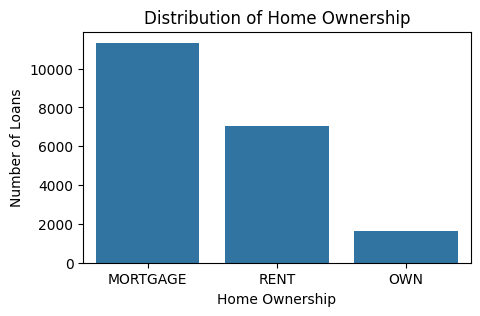

In [21]:
# Count occurrences of each home ownership type
home_ownership_counts = data['home_ownership'].value_counts()
plt.figure(figsize=(5, 3))
sns.barplot(x=home_ownership_counts.index, y=home_ownership_counts.values)
plt.xlabel('Home Ownership')
plt.ylabel('Number of Loans')
plt.title('Distribution of Home Ownership')
plt.show()


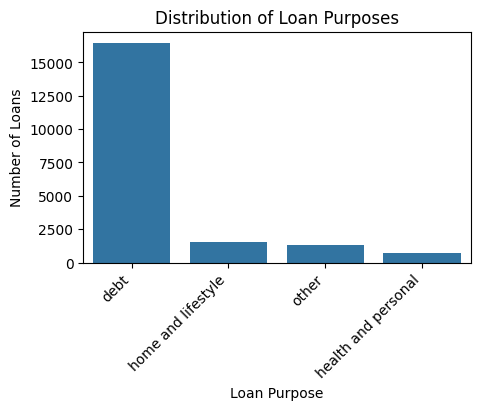

In [22]:
# Count occurrences of each loan purpose 

purpose_counts = data['purpose'].value_counts()
# Visualise the finding 
plt.figure(figsize=(5, 3))
sns.barplot(x=purpose_counts.index, y=purpose_counts.values)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.xlabel('Loan Purpose')
plt.ylabel('Number of Loans')
plt.title('Distribution of Loan Purposes')
plt.show()

In [23]:
# how many loans are termed at 36 months and 60 months

data['term'].value_counts()

term
36    15001
60     4999
Name: count, dtype: int64

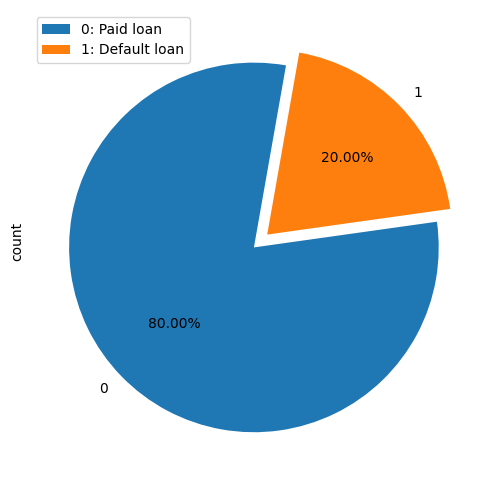

In [24]:
#Check how many bad loans vs paid loans
data.bad_loan.value_counts().plot(
    kind='pie', 
    subplots=True,
    autopct='%1.2f%%', 
    explode= (0.05, 0.05), 
    startangle=80, 
    legend=True,
    fontsize=10, 
    figsize=(7,6)) 
plt.legend(["0: Paid loan","1: Default loan"])

From the Pie chart it can be noticed that the distribution of paid and defaulted loans are imbalanced, ths will need to be taken in consideration when training the models. Imbalanced data could lead to classification models to be biased, and poor performance on minority class, therefore resampling of data will be necessary 

#### 3.2  Analysis of variables 

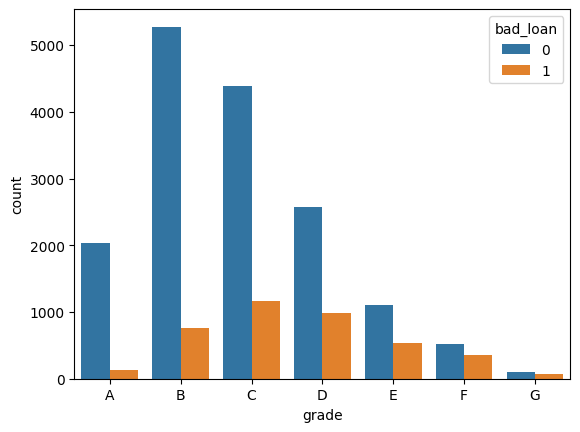

In [25]:
# visualise by grade type how many bad loans vs paid loans are 

mapping = {1:'A', 2:'B', 3:'C', 4:'D', 5:'E', 6:'F',7: 'G'}
sns.countplot(data=data,x=data['grade'],hue='bad_loan')
plt.xticks(ticks=range(len(mapping)), labels=[mapping[i] for i in mapping.keys()])
plt.show()

From the above chart it can be noticed that most defaulted loans are in Grade C in absolute values, however proportionally Grade G and F have the most defaults. 

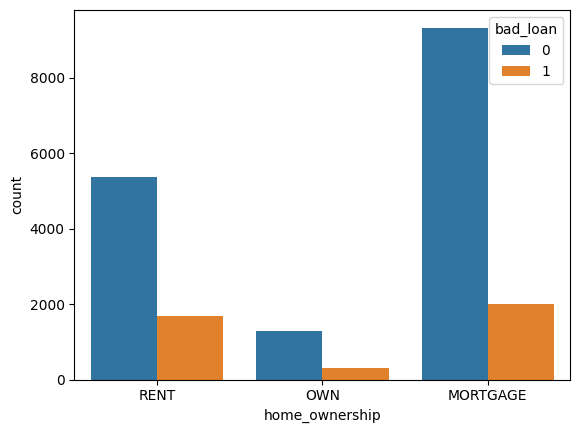

In [26]:

#visualise how many people who have paid their loans vs not by home ownership 

sns.countplot(data=data, x='home_ownership', hue='bad_loan')
plt.show()

From the chart above it can be noticed that people who rent prortionally have the most default of loans when compared to people who own their house or have a mortgage.

<Axes: xlabel='short_emp', ylabel='count'>

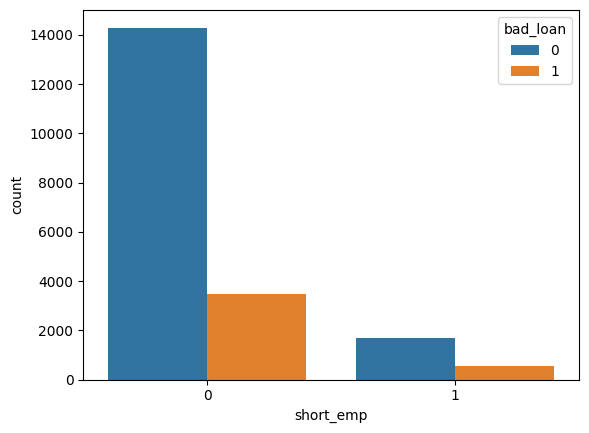

In [27]:
# visualise how many bad loans vs paid ones are by whether a person is short-term employed or not 

sns.countplot(data=data,x=data['short_emp'],hue='bad_loan')

From the chart above, it can be noticed that as a proportion of total loans taken by people who have been short term employed are more likely to default on their loan compared to people who are employed for longer than a year

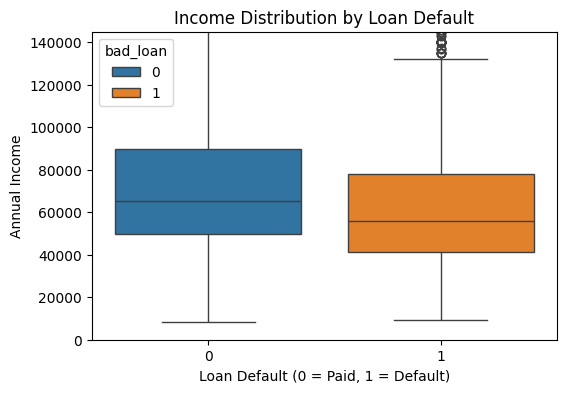

In [28]:
# Create a boxplot to compare annual income across loan default
plt.figure(figsize=(6, 4))
sns.boxplot(data=data, x='bad_loan', y='annual_inc', showfliers=True, hue='bad_loan')  # Remove outliers for clarity

plt.xlabel('Loan Default (0 = Paid, 1 = Default)')
plt.ylabel('Annual Income')
plt.title('Income Distribution by Loan Default')
plt.ylim(0, data['annual_inc'].quantile(0.95))  # Limit extreme outliers
plt.show()

From the chart above, it can be deducted that on median most loans which are paid are by people whose salaries are between 55,000-90,000, whilst the defaulted loans on median are usually taken by people whose salaray is between 41,000-75,000. The chart also shows that on annual income there are outliers. 

<function matplotlib.pyplot.show(close=None, block=None)>

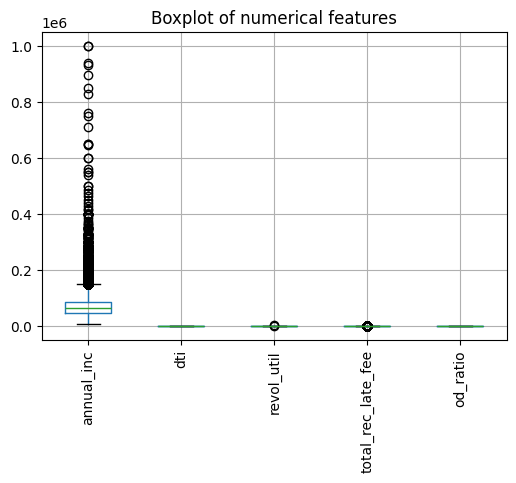

In [29]:
#check for outliers in the numerical columns 
columns= ['annual_inc','dti', 'revol_util', 'total_rec_late_fee','od_ratio']

plt.figure(figsize=(6,4))
data[columns].boxplot(rot=90)
plt.title("Boxplot of numerical features")
plt.show

From the chart above it can be seen that Annual income has outliers, as well as Revolve utilty and Total recollect fee. These will need to transformed otherwise it might impact the model's performance in a bad way. One way which these could be transformed is by applying log transformation to reduce skewness. 

In [30]:
#transform the outliers using log transfomation 

data['annual_inc']= np.log1p(data['annual_inc'])
data['revol_util']=np.log1p(data['revol_util'])
data['total_rec_late_fee']=np.sqrt(data['total_rec_late_fee']+1)

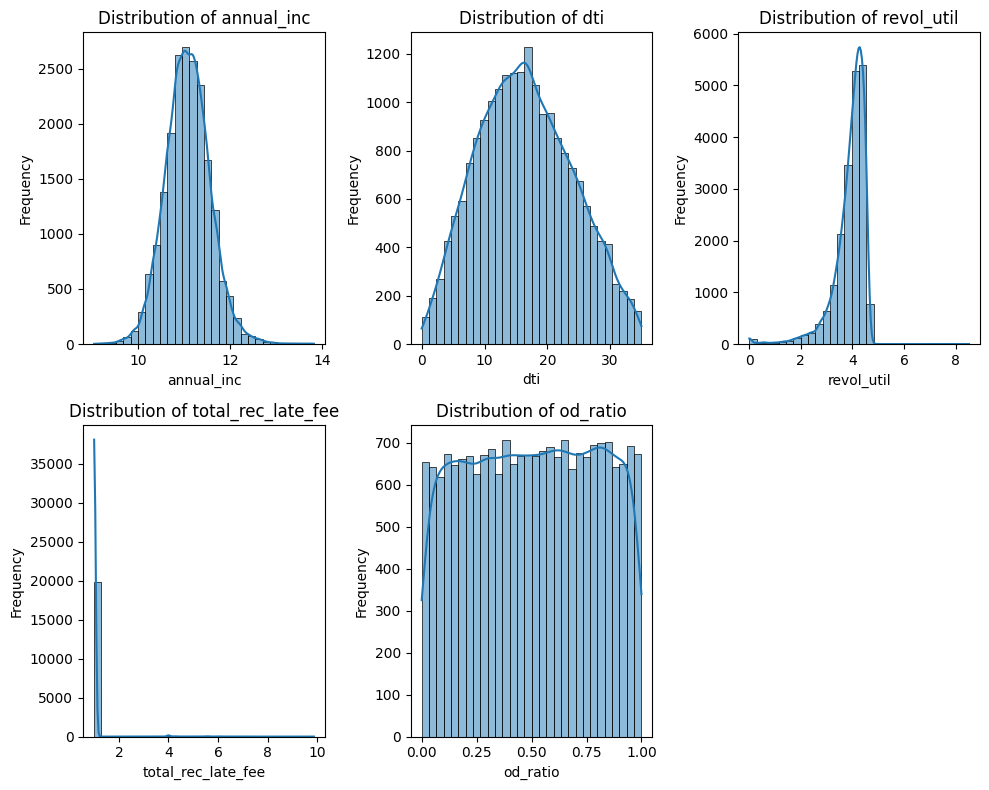

In [31]:
# plot histograms of the columns to see whether the data is normally distributed after is been transformed
plt.figure(figsize=(10, 8))
for i, column in enumerate(columns, 1):
    plt.subplot(2, len(columns)//2 + len(columns)%2, i)
    sns.histplot(data[column], kde=True, bins=30)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()
    

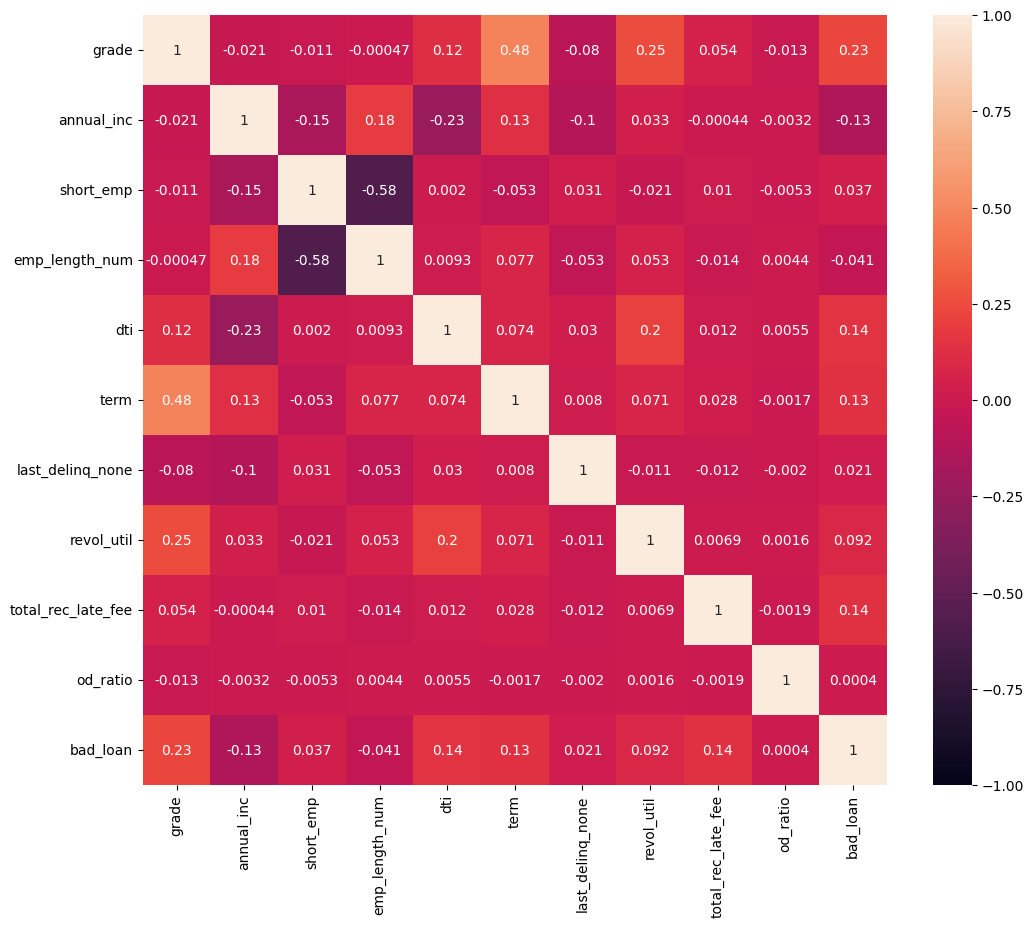

In [32]:
#visualise the correlation between variables using a heatmap
# only select columns that are numeric
data_numeric = data.select_dtypes(include=['number'])
#drop the ID 
data_numeric = data_numeric.drop(columns=['id'])

#plot the correlation matrix
plt.figure(figsize=(12,10))
sns.heatmap(data_numeric.corr(), annot=True, vmin=-1, vmax=1)

plt.show()

The heatmap above visualises the correlation between both numerical features in the dataset. Lighter colors indicate stronger correlations, whilst darker colors indicate weaker relationships between variables. From the heatmap it can be noticed that here are some positive and negative correlations amongst the variables, for example grade has a positive relationship with loan default, whilst annual income has a negative relationship with loan default. Short term employment and employment length has a negative correlation, which means as someone is employed for more months it is less likely that they would be short-term employed. 

#### 3.3 Feature Engineering

Following the EDA some features have been proven to be more useful in predicting loan default than others, however as a start all features will be used in the model


In [33]:
#feature engineering 

#categorical data 
categorical_features_for_encoding = ["home_ownership", "purpose"]
categorical_features2 = ['last_delinq_none', 'short_emp','home_ownership', 'purpose']
   
#numerifcal data 
numerical_features= [col for col in data.columns if col not in categorical_features2 and col != 'bad_loan']


In [34]:
#encoding the categorical data 
data_encoded = pd.get_dummies(data,columns=categorical_features_for_encoding, dtype=int)

#scale the numerical features
scaler=StandardScaler()
data_encoded[numerical_features]= scaler.fit_transform(data_encoded[numerical_features])

print(data_encoded.head(3))

         id     grade  annual_inc  short_emp  emp_length_num       dti  \
0  2.400653 -1.496242    0.894974          1       -1.542446  1.281326   
1  1.251411 -1.496242    0.512476          0       -0.747562 -1.481910   
2  1.301006  0.761952    0.384932          0        1.107167  0.246436   

       term  last_delinq_none  revol_util  total_rec_late_fee  od_ratio  \
0 -0.577273                 1   -0.172127           -0.102717 -1.194963   
1 -0.577273                 0   -1.223050           -0.102717  1.064764   
2  1.732282                 1   -0.066623           -0.102717 -1.631081   

   bad_loan  home_ownership_MORTGAGE  home_ownership_OWN  home_ownership_RENT  \
0         0                        0                   0                    1   
1         0                        0                   1                    0   
2         1                        1                   0                    0   

   purpose_debt  purpose_health and personal  purpose_home and lifestyle  \
0

In [35]:
#define predictors and target
X= data_encoded.drop(columns=['bad_loan','id'])
y=data_encoded['bad_loan']

In [36]:
#split the data 

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.80, test_size=0.2, random_state=2, stratify=y)



In [37]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (16000, 17)
X_test shape: (4000, 17)
y_train shape: (16000,)
y_test shape: (4000,)


### 4. Model development 

After performing exploratory data analysis (EDA), it is clear that the goal is to predict whether a loan will be bad (likely to default). Since this is a categorical outcome, where the target variable indicates whether a loan is bad or not, this is a classification problem, as such at this step supervised classification models will be developed. 

##### Random Forest


In [38]:
#Random Forest model 
rf_model=RandomForestClassifier(random_state=42)

# train the model on X_train and y_train 
rf_model.fit(X_train, y_train)

# Predict on the X_test 
y_pred_rf= rf_model.predict(X_test)

# Probability scores

y_proba_rf=rf_model.predict_proba(X_test)[:, 1]


#cross valifdation scores
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')


In [39]:
# Evaluate Random Forest model results
print("Randon Forest (Imbalanced Data):")
print(classification_report(y_test, y_pred_rf))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_rf ):.4f}")
print(f"Cross-validation scores: {cv_scores}")
print(f"Cross-validation mean score: {cv_scores.mean()}")

Randon Forest (Imbalanced Data):
              precision    recall  f1-score   support

           0       0.81      0.98      0.89      3200
           1       0.49      0.09      0.14       800

    accuracy                           0.80      4000
   macro avg       0.65      0.53      0.52      4000
weighted avg       0.75      0.80      0.74      4000

ROC-AUC: 0.6800
Cross-validation scores: [0.8040625 0.8009375 0.80375   0.8009375 0.79625  ]
Cross-validation mean score: 0.8011874999999999


In [40]:
# check if the model is overfitting 

train_accuracy = rf_model.score(X_train, y_train)
test_accuracy = rf_model.score(X_test, y_test)
print(f'Training accuracy: {train_accuracy:.4f}')
print(f'Testing accuracy: {test_accuracy:.4f}')

Training accuracy: 1.0000
Testing accuracy: 0.7995


**_Random Forest model has a high accurary (0.8) and low recall for bad loans (0.09) which suggests overfitting to the training data, this is further emphasised by the high training accuracy of (1.0000) which means the model is not able to generalise well to bad loans._**

**_The Precision (0.81) and Recall (0.98) for good loans are very high, meaning the model is able to predict correctly the good loans but struggles with bad loans precision (0.49) and recall (0.09), this could be due to overfitting but also due to imbalanced data. This proves that accuraccy alone is not always a good metric to rely, as in this case having an imabalnced model it predicted very well the good loans, but not the bad hence it does not answer the problem statement of this project_**

**_Cross validation score of 0.80 shows stability across different folds._**

##### Logistic Regression

In [41]:
#Logistic Regression Model 
lr_model=LogisticRegression(max_iter= 1000,random_state=1)

# Train the model on X_train_scaled and y_train
lr_model.fit(X_train, y_train)

# Make prediction on the test section 

y_pred_lr= lr_model.predict(X_test)

# Probability scores

y_proba_lr=lr_model.predict_proba(X_test)[:, 1]

# Cross validation scores
cv_scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='accuracy')

In [42]:
# Evaluate the logistic Regression Model 

print("Logistic Regression (Imbalanced Data):")
print(classification_report(y_test, y_pred_lr))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_lr ):.4f}")
print(f"Cross-validation scores: {cv_scores}")
print(f"Cross-validation mean score: {cv_scores.mean()}")

Logistic Regression (Imbalanced Data):
              precision    recall  f1-score   support

           0       0.81      0.99      0.89      3200
           1       0.54      0.07      0.12       800

    accuracy                           0.80      4000
   macro avg       0.67      0.53      0.51      4000
weighted avg       0.75      0.80      0.74      4000

ROC-AUC: 0.6922
Cross-validation scores: [0.806875  0.8096875 0.8075    0.8075    0.8003125]
Cross-validation mean score: 0.8063750000000001


In [43]:
# check if the model is overfitting 

train_accuracy = lr_model.score(X_train, y_train)
test_accuracy = lr_model.score(X_test, y_test)
print(f'Training accuracy: {train_accuracy:.4f}')
print(f'Testing accuracy: {test_accuracy:.4f}')

Training accuracy: 0.8066
Testing accuracy: 0.8020


**_The Logistic Regression Model has an accuracy of 0.80, which is exact as the Random Forest model(0.80), however the LogReg has been able to predict bad loans better than RF as it has a higher precision score of 0.54, and recall of 0.07, these values are still considered low, therefore more improvments are needed. On predicting good loans, the model has good precision (0.81) and recall (0.99)._**

**_Cross validtion scores with mean of 0.81, and with consistent performance across folds. Lastly there is no overfitting, as seen by stable train and test accuraccy. However the ROC is only 0.69, which means the model might still struggle to differentiate between classes_**

##### KNN Classifier

In [44]:
# KNN classifier 
knn_model= KNeighborsClassifier(n_neighbors=4)

# Train the model
knn_model.fit(X_train, y_train)

#Predict on the test set

y_pred_knn = knn_model.predict(X_test)

#Probability score

y_proba_knn= knn_model.predict_proba(X_test)[:, 1]

# Cross validation scores
cv_scores = cross_val_score(knn_model, X_train, y_train, cv=5, scoring='accuracy')

In [45]:
# Evaluate the KNN classifier model 

print("KNN Model:(Imbalanced Data)")
print(classification_report(y_test, y_pred_knn))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_knn ):.4f}")
print(f"Cross-validation scores: {cv_scores}")
print(f"Cross-validation mean score: {cv_scores.mean()}")

KNN Model:(Imbalanced Data)
              precision    recall  f1-score   support

           0       0.81      0.97      0.88      3200
           1       0.41      0.10      0.16       800

    accuracy                           0.79      4000
   macro avg       0.61      0.53      0.52      4000
weighted avg       0.73      0.79      0.74      4000

ROC-AUC: 0.6212
Cross-validation scores: [0.794375  0.793125  0.7903125 0.796875  0.7928125]
Cross-validation mean score: 0.7935000000000001


In [46]:
# check if the model is overfitting 

train_accuracy = knn_model.score(X_train, y_train)
test_accuracy = knn_model.score(X_test, y_test)
print(f'Training accuracy: {train_accuracy:.4f}')
print(f'Testing accuracy: {test_accuracy:.4f}')

Training accuracy: 0.8315
Testing accuracy: 0.7917


**_KNN Classifier Model has an overall 0.79 accuracy. The model performs well on predicting good loans, however it struggles with bad loans, as indictaed by low precision (0.41) and low recall (0.1). The ROC AUC of 0.62 suggest the model is not distinguishing well between classes(good vs bad loans). The KNN model has performed worse off than Random Forest and Logistic regression, which means that for this problem KNN is not ideal._**

#### Random Forest Parameter tunning and adressing overfitting


Out of the three models Logistic Regression and Random Forest have performed better than KNN. However, Random Forest model will be chosen to further improve through balancing the data and to hyperparameter tuning due to the fact that Random Forest can handle non-linear relationships better, and is able to provides feature importance, which facilitates in understanding key factors contributing to bad loans. (Beheshti,2023)

Also, with imbalanced data, relying on accuracy alone isn't enough, as it may overlook the minority class (bad loans). Metrics like ROC, Recall, and F1-Score are better suited for this project. (Brownlee,2021)

In [47]:
#undersample data using ENN to balance the dataset, this also helps remove noise 
enn= EditedNearestNeighbours(sampling_strategy= 'majority', n_neighbors=8)
X_train, y_train= enn.fit_resample(X_train,y_train)

enn= EditedNearestNeighbours(sampling_strategy= 'majority', n_neighbors=8)
X_test, y_test= enn.fit_resample(X_test,y_test)


C:\Miniconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Miniconda3\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The EditedNearestNeighbours or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
C:\Miniconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.vali

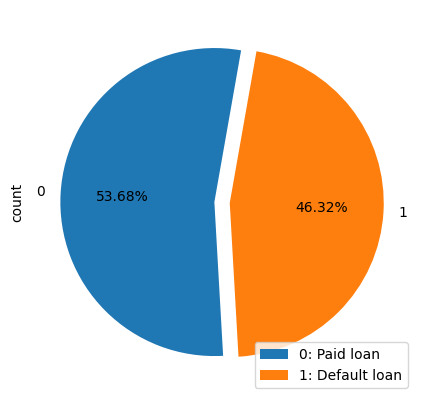

In [48]:
#Check whether the bad loans in the training set is balanced now
y_train.value_counts().plot(
    kind='pie', 
    subplots=True,
    autopct='%1.2f%%', 
    explode= (0.05, 0.05), 
    startangle=80, 
    legend=True,
    fontsize=10, 
    figsize=(5,5)) 
plt.legend(["0: Paid loan","1: Default loan"])

In [49]:
#Runing this code takes quite a while.
#the results from this is saved in the code snipet below where the best parameters are used, 
#therefore is not mandatory to run if time does not allow

#hyperparametr tuning
param_grid = {
    'n_estimators': [500, 300, 200],
    'max_depth': [None, 10],
    'min_samples_split': [150,200,250],
    'max_features': ['sqrt', None],
    'min_samples_leaf': [1,3],
    'bootstrap': [True]
}

def custom_score(y_true, y_prob):
    y_pred =(y_prob[:,1]>= 0.35).astype(int)
    return precision_score(y_true, y_pred, pos_label=1)


scorer=make_scorer(custom_score, needs_proba=True)

rf =RandomForestClassifier(random_state=2)

grid_search= GridSearchCV(rf,param_grid, scoring='f1', cv=5, n_jobs=1,verbose=1)

grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_

print("Best Parameters: ", grid_search.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters:  {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 150, 'n_estimators': 500}


In [50]:
#Random Forest model once the best parameters are found and implemented
rf_model_1= RandomForestClassifier(n_estimators=500,
                                min_samples_split=150,
                                max_features='sqrt',
                                max_depth=None,
                                bootstrap=True, 
                                min_samples_leaf=1,
                                random_state=1
                                 )
#fitting the data 
rf_model_1.fit(X_train, y_train)

# Predict on the X_test 

y_pred_rf= rf_model_1.predict(X_test)


# Probability scores

y_proba_rf=rf_model_1.predict_proba(X_test)[:, 1]

y_pred_rf= (y_proba_rf >= 0.36).astype(int)

#cross valifdation scores
cv_scores = cross_val_score(rf_model_1, X_train, y_train, cv=5, scoring='accuracy')


##### Model Evaluation

This is the stage were the final model is evaluated. The final model for this task is Random Forest, where the hyperparameter tuning was performed and the best parameters were found. First, it will be evaluated the accuarcy of training vs testing to see whether there are any signs of overfitting. Then the classification report will be computed, given the problem and question analysis, in this case we would want the model to be able to identify correctly bad loans and we would also want the model to not mistake bad loans for good ones, as that would mean that there will be a risk of default that the model has missed. Therefore, the metrics that the model should score high in order to answer the analysis question is __precision for good loans__, meaning no false positives which have a big impact on bank's capital, then the next metric that the model should score high is the __recall for bad loans__ meaning the model is able to identify correctly most bad loans. We would aslo want a high ROC meaning that the model can differentiate well between classes.

In [51]:
#checking the accuracy of train and test set to see if the model is overfitting 
train_accuracy = rf_model_1.score(X_train, y_train)
test_accuracy = rf_model_1.score(X_test, y_test)
print(f'Training accuracy: {train_accuracy:.4f}')
print(f'Testing accuracy: {test_accuracy:.4f}')

Training accuracy: 0.8259
Testing accuracy: 0.7828


In [52]:
#classifiction report 
print("Randon Forest (Balanced Data):")
print(classification_report(y_test, y_pred_rf))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_rf ):.4f}")
print(f"Cross-validation scores: {cv_scores}")
print(f"Cross-validation mean score: {cv_scores.mean()}")

Randon Forest (Balanced Data):
              precision    recall  f1-score   support

           0       0.84      0.65      0.73       871
           1       0.69      0.87      0.77       800

    accuracy                           0.75      1671
   macro avg       0.77      0.76      0.75      1671
weighted avg       0.77      0.75      0.75      1671

ROC-AUC: 0.8601
Cross-validation scores: [0.80535456 0.80318379 0.8089725  0.81041968 0.8044895 ]
Cross-validation mean score: 0.8064840071635835


In [53]:
#find out what is the ROC-AUC score
fpr, tpr,_ = roc_curve(y_test, y_proba_rf)
roc_auc= auc(fpr,tpr)

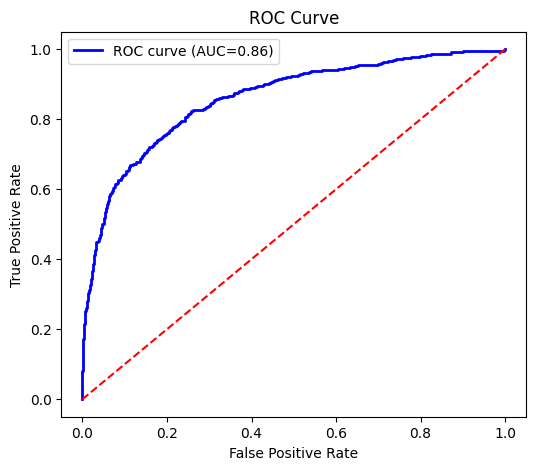

In [54]:
#plot the results and find out the ROC curve 
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (AUC={roc_auc:.2f})")
plt.plot([0,1], [0,1], color='red', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [55]:
#create the confusion matrix 
cm = confusion_matrix(y_test, y_pred_rf)

<function matplotlib.pyplot.show(close=None, block=None)>

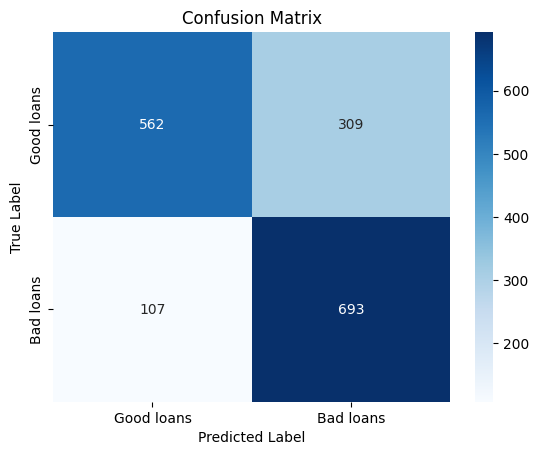

In [56]:
#plot the confusion matrix using a heatmap

plt.figure(figure=(2,2))
sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            xticklabels= ["Good loans", "Bad loans"], 
            yticklabels=["Good loans", "Bad loans"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show 

### 5. Visualisations 

In [57]:
importances = rf_model_1.feature_importances_
feature_names = X_train.columns

indices = np.argsort(importances)[::-1]

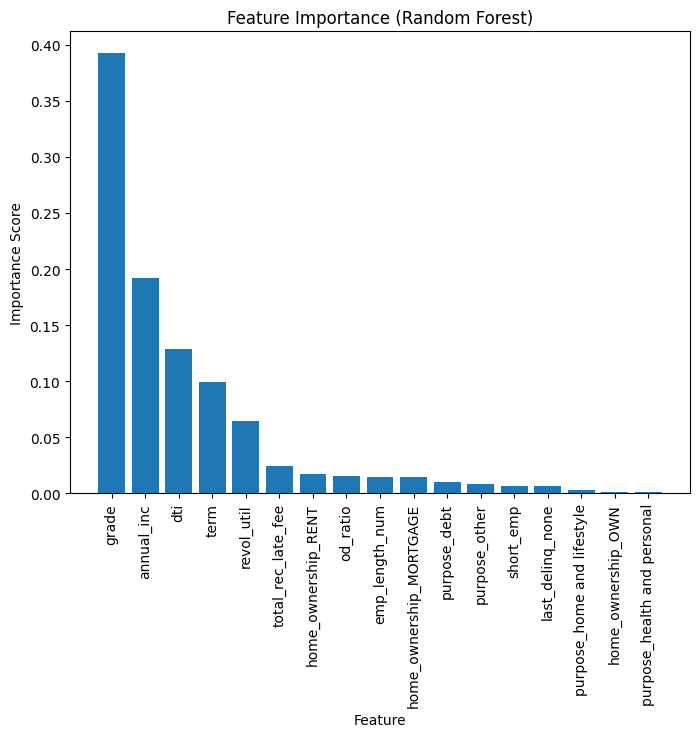

In [58]:
# Plot feature importance 

plt.figure(figsize= (8,6))
plt.title("Feature Importance (Random Forest)")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.show()

The chart above shows that the most important features in the Final Random Forest is grade, annual income, dti,  revol_util, term, and total_rec_late_fee. The rest of the features seem to have less importance, however upon testing removing the features lowers the accuracy of model meaning that even if their importance is not as high, they still contribute in a small amount to the model

<function matplotlib.pyplot.show(close=None, block=None)>

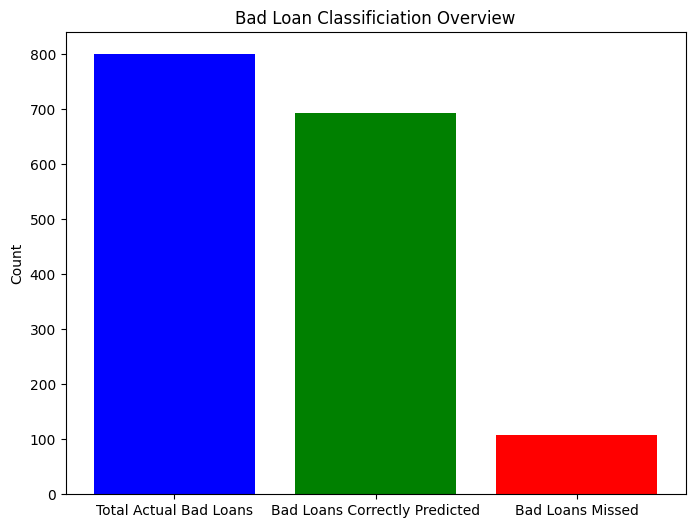

In [59]:
total_bad_loans= np.sum(y_test== 1)
correct_bad_loans = np.sum((y_test==1)& (y_pred_rf==1))
missed_bad_loans = np.sum((y_test==1)& (y_pred_rf==0))

# create a plot bar 
labels = ['Total Actual Bad Loans', 'Bad Loans Correctly Predicted', 'Bad Loans Missed']
values = [total_bad_loans, correct_bad_loans, missed_bad_loans]

#ploting the bar chart
plt.figure(figsize=(8,6))
plt.bar(labels,values,color=['blue', 'green', 'red'])
plt.title('Bad Loan Classificiation Overview')
plt.ylabel('Count')
plt.show

The chart above shows a bar chart with 3 bars:

-the first blue bar shows the total bad loans in the y_test set

-the second green bar shows the total bad loans that were correctly predicted 

-the third red bar shows the missed bad loans that the model misclasified as good loans. 

On average the model is able to predict most bad loans as bad, however there still are some loans which the model is not able to predict correctly as bad loans. This means that those missed loans would be a risk for the bank, and would affect the capital of a bank negatively, however as per Basel standards for credit risk there are assumptions in place that some loans will default, these metrics are know as Probability of default, loss given default and exposure at default, these will inform the amount of capital a bank will need to hold. Basel's approach to credit risk is that some loans are bound to default,  as such it is not expected that our machine learning model to predict every single bad loan, as banks will hold buffers of capital for such loans, however it can be seen that most bad loans the model can predict with high accuracy of 0.87%. 

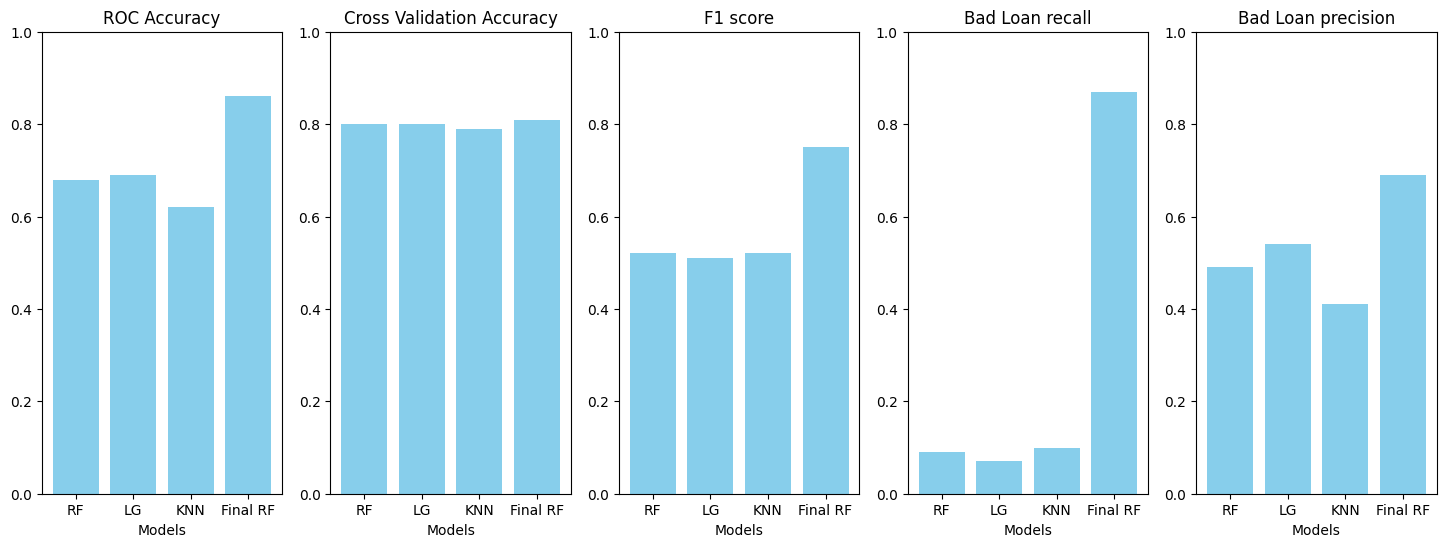

In [60]:
# compare the models 

models = ['RF', 
          'LG',
          'KNN', 
          'Final RF']
roc_accuracy= [0.68, 0.69, 0.62, 0.86]
cross_validation_acc=[0.80,0.80,0.79,0.81]
f1_score_macro = [0.52,0.51,0.52,0.75]
bad_loan_recall = [0.09, 0.07,0.1,0.87]
bad_loan_precision =[0.49,0.54,0.41,0.69]

#bar width
bar_width=0.2
index=np.arange(len(models))

#create the plot
fig, axs=plt.subplots(1,5, figsize=(18,6))

#bar plot for roc_accuracy 
axs[0].bar(models, roc_accuracy, color='skyblue')
axs[0].set_title('ROC Accuracy')
axs[0].set_ylim(0,1)
axs[0].set_xlabel('Models')

#bar plot for cross validation
axs[1].bar(models, cross_validation_acc, color='skyblue')
axs[1].set_title('Cross Validation Accuracy')
axs[1].set_ylim(0,1)
axs[1].set_xlabel('Models')

    
#bar plot for f1 score
axs[2].bar(models,f1_score_macro, color='skyblue')
axs[2].set_title('F1 score')
axs[2].set_ylim(0,1)
axs[2].set_xlabel('Models')

    
#bar plot for bad loan recall score
axs[3].bar(models,bad_loan_recall, color='skyblue')
axs[3].set_title('Bad Loan recall')
axs[3].set_ylim(0,1)
axs[3].set_xlabel('Models')

#bar plot for bad loan recall score
axs[4].bar(models,bad_loan_precision, color='skyblue')
axs[4].set_title('Bad Loan precision')
axs[4].set_ylim(0,1)
axs[4].set_xlabel('Models')


plt.tight_layout
plt.show()

From the chart above, it can be noticed that the Final Random Forest model,where the data for training set was balanced using undersampling method ENN has outperformed all of the other models where the data was not balanced. 

The models before the data was balanced have not performed well in terms of identyfind correctly bad loans as it can be seen in the Bad Loan recall, however it can be noticed that overall Random forest before balancing the data has outperformed the Logistic Regression model and KNN model before oversampling. This could be due to the fact that Random Forest can handle non-linearity, is able to handle imbalanced data better and can rank feature by importance whilst Logistic regression assigns coefficients which may not capture non-linear effects, and KNN relies on data between data points. 

Another point that can be seen in the chart above is that relying on accuracy alone would lead to misleading conclusions, especially because the dataset is not balanced (80% good loans vs 20% bad loans). Given the problem statement of this project and questions the main focus is ability to identify correctly bad loans, and have as little as possible bad loans identified as bad loans, therefore other metrics such as recall, precision, ROC are better suited for this project. 


### 7. Conclusion

The Final Random forest model for bad loans has a high recall of 0.87% meaning is able to identify with high accuracy, and an ROC of 0.86% meaning is able to differentiate well between classes. This model is able to answer the problem question, and it can predict well bad loans for regulatory purposes. The model does miss some bad loans, however as per Basel Standards which sets the rules for banks on how much capital to hold, one of the assumption is that some loans will inevitably default, and therefore the banks will hold capital buffers for such instances. Our model is not able to identify all bad loans, but given the rules also state that is not possible for firms to predict with 100% certainty bad loans, our model shows that Banks can use Machine learning techniques for their credit assesment, especially when it comes for regulatory purposes where the focus is identyfing bad loans to inform Bank's capital buffers. 

One limitation that should be noted is that the data used for this model is syntethic,which means it may not capture all complexities of real financial data, and also the dataset is quite small 20,000 observation. In a real-world sceanario, banks will have a lot more observations, meaning their model is a lot more complex, which will require a lot more comptutational power. However, in a real world scenario with more data, the model is expected to perform even better, both because of more data points for the model to train, and more meaningful relationships between variables. 

### 8. References 

Bank of England (2022). Machine learning in UK financial services. [online] www.bankofengland.co.uk. Available at: https://www.bankofengland.co.uk/report/2022/machine-learning-in-uk-financial-services.

Beheshti, A. (2023). Comparing Popular Classification Algorithms - Ashkan Beheshti - Medium. [online] Medium. Available at: https://behesht.medium.com/classification-determining-the-appropriate-model-support-vector-machine-or-logistic-regression-4a559b06244a.

Brownlee, J. (2019). Failure of Classification Accuracy for Imbalanced Class Distributions. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/failure-of-accuracy-for-imbalanced-class-distributions/.

Qusay AL-Btoush (2022). Machine Learning . [online] Kaggle.com. Available at: https://www.kaggle.com/datasets/qusaybtoush1990/machine-learning/data 